In [1]:
""" 
alpha : 
bias_vwap = -(close - ts_mean(vwap, 3))
"""

' \nalpha : \nbias_vwap = -(close - ts_mean(vwap, 3))\n'

In [2]:
# Cell 1: Import necessary libraries and load data
import pandas as pd
import os
from pathlib import Path
from typing import Union, List

def load_crypto_data(
    base_path: Union[str, Path],
    symbol: str = "BTCUSDT",
    year: str = "2024",
    freq: str = "1m"
) -> pd.DataFrame:
    """
    加載並合併特定交易對的所有每日CSV文件
    
    Args:
        base_path (str/Path): 數據文件的基礎路徑
        symbol (str): 交易對名稱，如 "BTCUSDT"
        year (str): 年份，如 "2022"
        freq (str): 頻率，如 "1m"
    
    Returns:
        pd.DataFrame: 合併後的DataFrame
    """
    # 確保base_path是Path對象
    base_path = Path(base_path)
    
    # 構建文件匹配模式
    pattern = f"{symbol}_{year}-*_{freq}.csv"
    
    # 獲取所有匹配的文件並排序
    csv_files = sorted(list(base_path.glob(pattern)))
    
    if not csv_files:
        raise ValueError(f"No files found matching pattern: {pattern}")
    
    # 讀取並合併所有CSV文件
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    # 合併所有DataFrame
    if not dfs:
        raise ValueError("No data was successfully loaded")
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # 確保時間列正確格式化
    merged_df['open_time'] = pd.to_datetime(merged_df['open_time'])
    merged_df['close_time'] = pd.to_datetime(merged_df['close_time'])
    
    # 按時間排序
    merged_df = merged_df.sort_values('open_time').reset_index(drop=True)
    
    # 檢查並移除重複數據
    merged_df = merged_df.drop_duplicates(subset=['open_time'], keep='first')
    
    return merged_df

def check_data_quality(df: pd.DataFrame) -> dict:
    """
    檢查合併後數據的質量
    
    Args:
        df (pd.DataFrame): 待檢查的DataFrame
    
    Returns:
        dict: 包含各種數據質量指標的字典
    """
    quality_report = {
        'total_rows': len(df),
        'date_range': (df['open_time'].min(), df['open_time'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicate_times': len(df) - len(df['open_time'].unique()),
    }
    
    # 檢查時間間隔
    time_diffs = df['open_time'].diff().value_counts()
    quality_report['time_intervals'] = time_diffs
    
    return quality_report



In [3]:
# Cell 2: Load and prepare data
# 假設數據路徑
data_path = "/Users/mouyasushi/Desktop/quantDevops/Backtest_Performance/Alpha-Research/kline/binance/BTCUSDT/1m"

# 加載數據
btc_data = load_crypto_data(
    base_path=data_path,
    symbol="BTCUSDT",
    year="2024",
    freq="1m"
)

# 檢查數據質量
quality_report = check_data_quality(btc_data)

# 輸出基本信息
print(f"Loaded data shape: {btc_data.shape}")
print(f"Date range: {quality_report['date_range']}")
print(f"Total rows: {quality_report['total_rows']}")



Loaded data shape: (488160, 12)
Date range: (Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-04 23:59:00'))
Total rows: 488160


In [4]:
# Set index to open_time
btc_data = btc_data.set_index('open_time')

btc_data

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,
2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,0
2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0
2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0
2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0
2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04 23:55:00,98803.5,98835.0,98775.7,98786.1,70.970,2024-12-04 23:55:59.999,7.012476e+06,1567,35.110,3.469313e+06,0
2024-12-04 23:56:00,98786.1,98792.9,98734.6,98770.7,151.892,2024-12-04 23:56:59.999,1.499998e+07,2414,51.604,5.096036e+06,0
2024-12-04 23:57:00,98770.7,98778.0,98740.1,98769.9,73.575,2024-12-04 23:57:59.999,7.265887e+06,1396,19.852,1.960477e+06,0


In [5]:
# Cell 3: Alpha description
"""
Alpha formula:

bias_vwap = -(close - ts_mean(vwap, 3))

This alpha measures the deviation of current price from the 3-period moving average of VWAP.
A positive value indicates the price is below the average VWAP (potential buying opportunity),
while a negative value indicates the price is above the average VWAP (potential selling opportunity).
"""

# Cell 4: Import libraries for alpha analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def ts_mean(series, window):
    """
    Time series mean over a rolling window using only past data
    """
    return series.rolling(window=window).mean()

def calculate_vwap(df):
    """
    Calculate VWAP (Volume Weighted Average Price)
    """
    df = df.copy()
    # VWAP = sum(price * volume) / sum(volume)
    df['vwap'] = ((df['close'] * df['volume']).rolling(window=1).sum() / 
                 df['volume'].rolling(window=1).sum())
    return df

def calculate_alpha(df):
    """
    Calculate alpha: -(close - ts_mean(vwap, 3))
    with look-ahead bias prevention
    """
    df = df.copy()
    
    # Calculate VWAP
    df = calculate_vwap(df)
    
    # Shift prices and VWAP to ensure we only use past data
    close_lag = df['close'].shift(1)
    vwap_lag = df['vwap'].shift(1)
    
    # Calculate ts_mean using lagged VWAP data
    vwap_mean = ts_mean(vwap_lag, 3)
    
    # Calculate the alpha
    alpha = -(close_lag - vwap_mean)
    
    return alpha



In [6]:
def calculate_forward_returns(df, periods=[1, 5, 10]):
    """
    Calculate forward returns for multiple periods
    """
    returns = {}
    for period in periods:
        returns[f'forward_return_{period}'] = (
            df['close'].shift(-period) / df['close'] - 1
        )
    return pd.DataFrame(returns, index=df.index)

def calculate_rolling_ic(signals, returns, window=252):
    """
    Calculate rolling Information Coefficient
    """
    rolling_ic = pd.Series(index=signals.index, dtype=float)
    
    for i in range(window, len(signals)):
        if i % 1000 == 0:  # Progress indicator
            print(f"Processing IC calculation: {i}/{len(signals)}", end='\r')
            
        s_window = signals.iloc[i-window:i]
        r_window = returns.iloc[i-window:i]
        valid_data = ~(s_window.isna() | r_window.isna())
        if valid_data.sum() > 0:
            rolling_ic.iloc[i] = stats.spearmanr(
                s_window[valid_data], 
                r_window[valid_data]
            )[0]
            
    return rolling_ic

def analyze_alpha(df, alpha_name='alpha', periods=[1, 5, 10]):
    """
    Comprehensive alpha analysis with look-ahead bias prevention
    """
    df = df.copy()
    results = {}
    
    # Calculate alpha first (using only past data)
    print("Calculating alpha...")
    df['alpha'] = calculate_alpha(df)
    
    # Calculate forward returns (our targets)
    print("Calculating forward returns...")
    forward_returns = calculate_forward_returns(df, periods)
    df = pd.concat([df, forward_returns], axis=1)
    
    # Shift alpha to ensure we're using past signal for future returns
    df['alpha_lag'] = df['alpha'].shift(1)
    
    # Remove NaN values
    df = df.dropna()
    
    print("Running period analysis...")
    for period in periods:
        print(f"\nAnalyzing period {period}...")
        return_col = f'forward_return_{period}'
        period_results = {}
        
        # Calculate IC using lagged alpha
        ic = stats.spearmanr(df['alpha_lag'], df[return_col])[0]
        period_results['IC'] = ic
        
        # Calculate rolling IC
        print(f"Calculating rolling IC for period {period}...")
        rolling_ic = calculate_rolling_ic(df['alpha_lag'], df[return_col])
        valid_ic = rolling_ic.dropna()
        if len(valid_ic) > 0:
            icir = valid_ic.mean() / valid_ic.std()
            period_results['ICIR'] = icir
        else:
            period_results['ICIR'] = np.nan
        
        # Calculate turnover
        period_results['turnover'] = (
            df['alpha_lag'].diff().abs().mean() / df['alpha_lag'].abs().mean()
        )
        
        # Calculate quintile returns
        try:
            quintiles = pd.qcut(df['alpha_lag'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
            quintile_returns = df.groupby(quintiles)[return_col].mean()
            period_results['quintile_returns'] = quintile_returns
            
            # Calculate spread (Q5-Q1)
            period_results['spread'] = quintile_returns['Q5'] - quintile_returns['Q1']
            
            # Calculate t-stat of spread
            spread_series = df[df['alpha_lag'] >= df['alpha_lag'].quantile(0.8)][return_col] - \
                          df[df['alpha_lag'] <= df['alpha_lag'].quantile(0.2)][return_col]
            t_stat = np.sqrt(len(spread_series)) * spread_series.mean() / spread_series.std()
            period_results['t_stat'] = t_stat
            
        except Exception as e:
            print(f"Error in quintile calculation for period {period}: {e}")
            continue
            
        results[period] = period_results
    
    return results, df

def plot_quintile_analysis(results, period):
    """
    Plot quintile analysis
    """
    plt.figure(figsize=(10, 6))
    quintile_returns = results[period]['quintile_returns']
    
    bars = plt.bar(range(len(quintile_returns)), quintile_returns * 1e5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.title(f'Quintile Returns Analysis for VWAP Bias Alpha (Period: {period})\nUsing Past Data Only')
    plt.xlabel('Quintiles')
    plt.ylabel('Average Return (1e-5)')
    plt.xticks(range(len(quintile_returns)), quintile_returns.index)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt



Starting VWAP Bias Alpha analysis...
Loading data...

Starting VWAP Bias alpha analysis with look-ahead bias prevention...
Data range: 2024-01-01 00:00:00 to 2024-12-04 23:59:00
Total rows: 488160
Calculating alpha...
Calculating forward returns...
Running period analysis...

Analyzing period 1...
Calculating rolling IC for period 1...
Processing IC calculation: 488000/488115
Analyzing period 5...
Calculating rolling IC for period 5...
Processing IC calculation: 488000/488115
Analyzing period 10...
Calculating rolling IC for period 10...
Processing IC calculation: 488000/488115
Period 1 Analysis (Using Past Data Only):
--------------------------------------------------
Information Coefficient (IC): 0.0128
IC-IR: 0.2797
Turnover: 1.1244
Q5-Q1 Spread: 1.2148 (1e-5)
T-Statistic: nan

Quintile Returns (1e-5):
alpha_lag
Q1   -0.345317
Q2   -0.100785
Q3    0.016980
Q4    0.573943
Q5    0.869482
Name: forward_return_1, dtype: float64

Period 5 Analysis (Using Past Data Only):
----------------

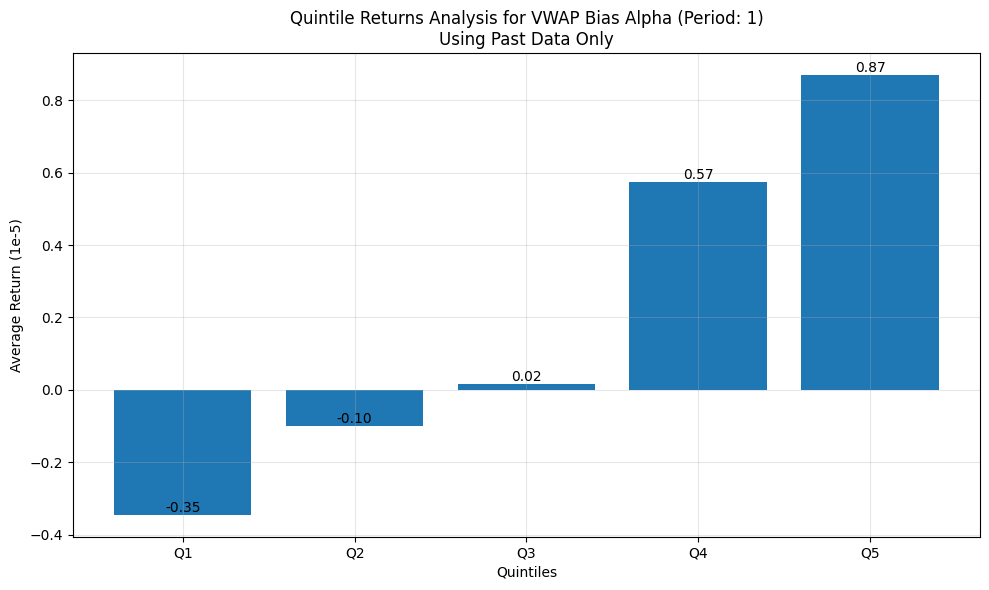

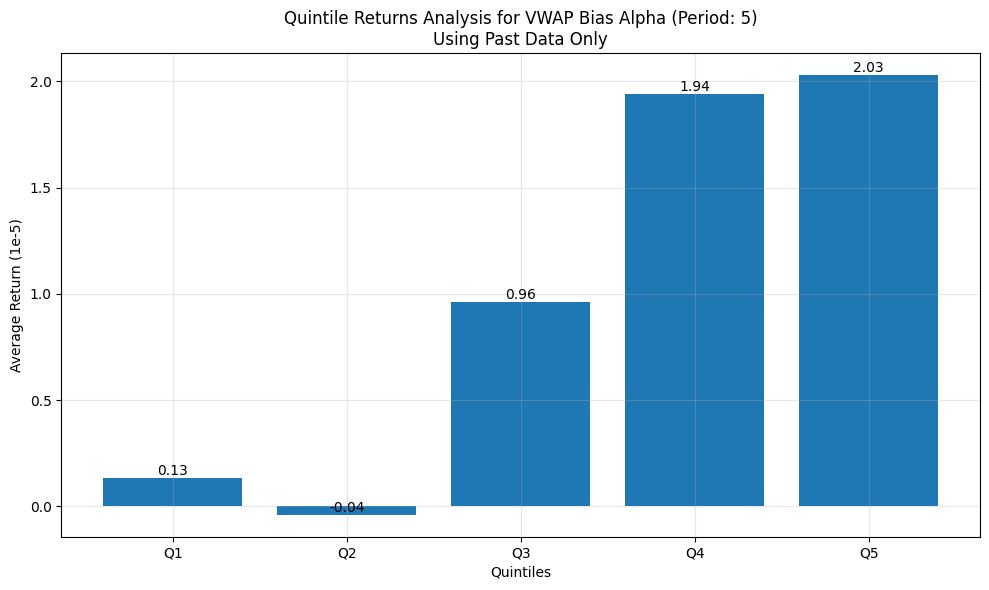

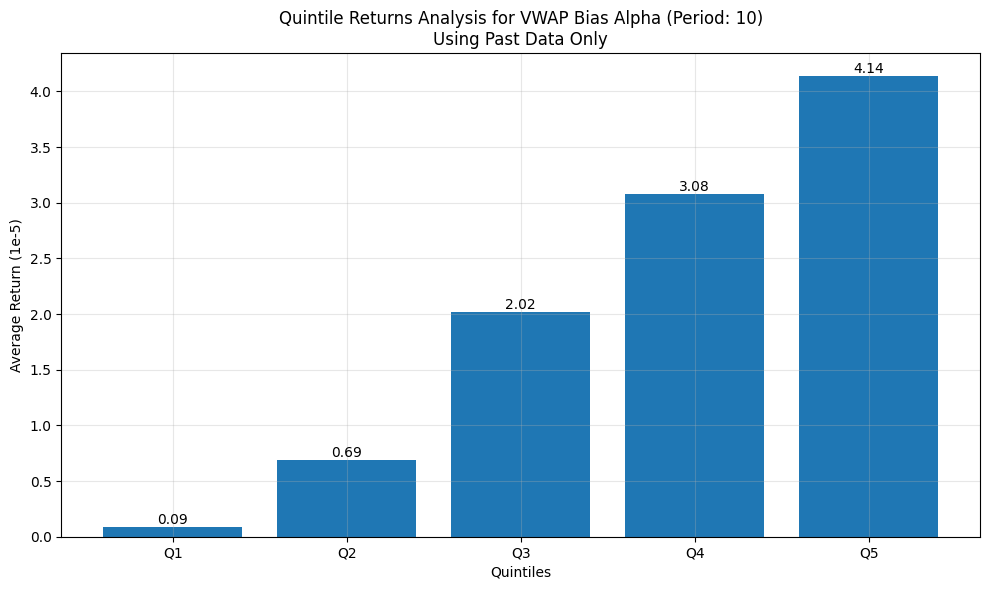

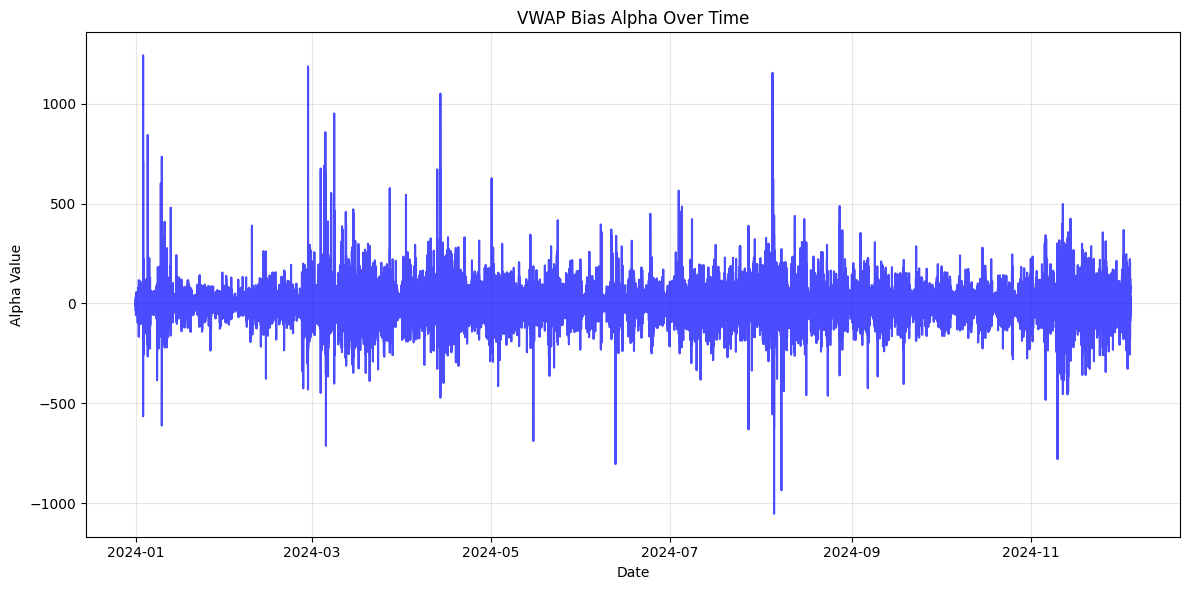

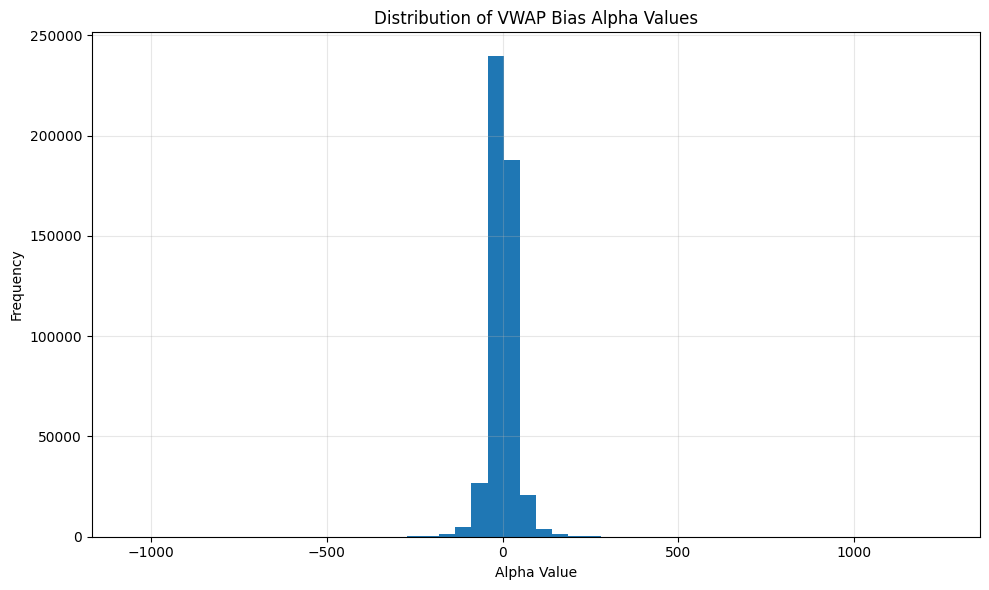

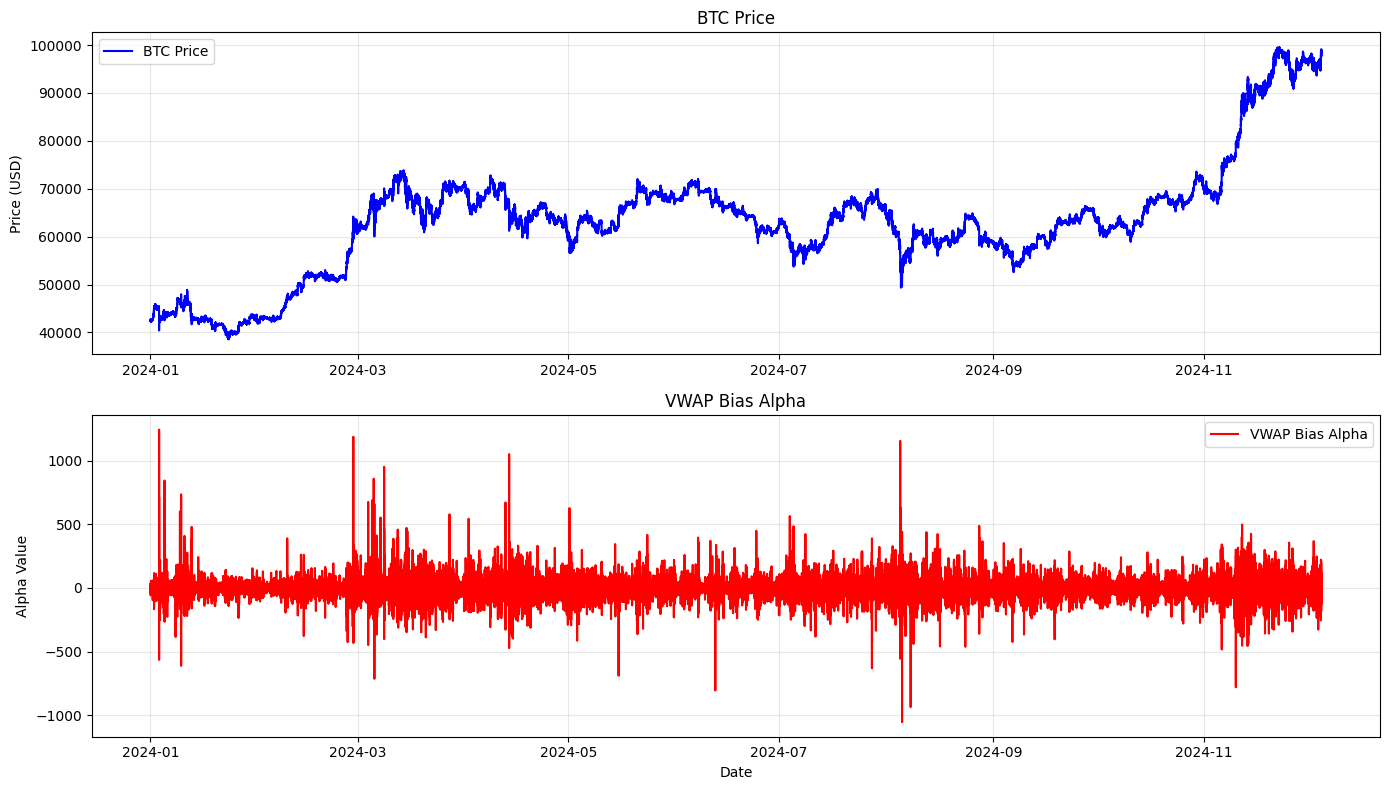

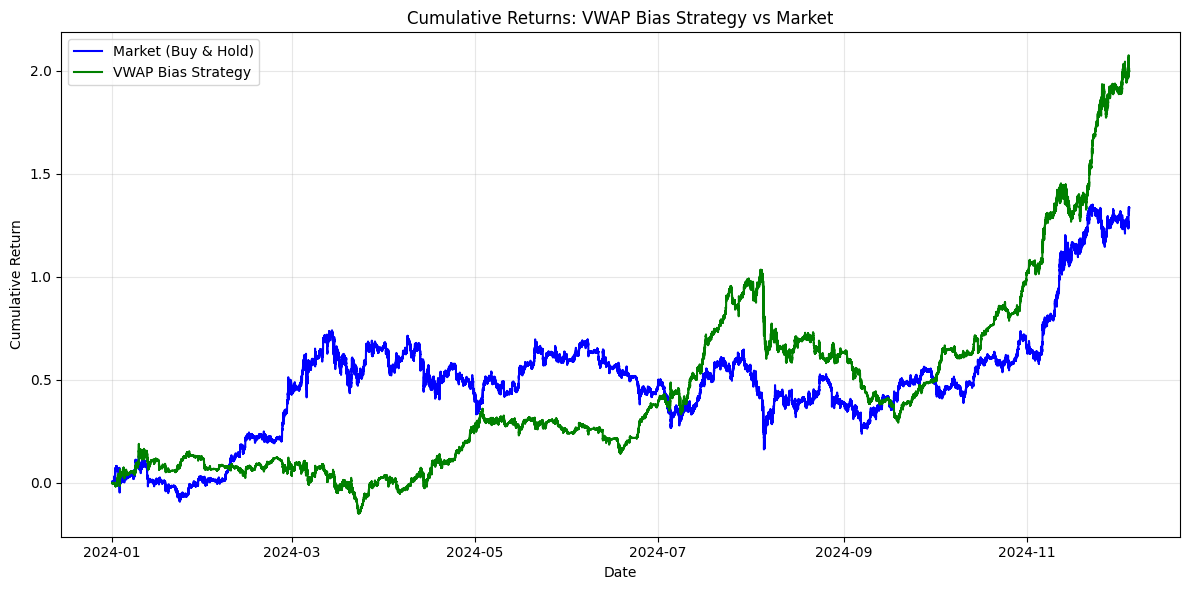

Total Return: 1.998217
Annual Return: 0.883410
Annual Volatility: 0.366279
Sharpe Ratio: 2.411853
Max Drawdown: 0.742543
Win Rate: 0.506891
Profit Factor: 1.019647


In [7]:
def print_analysis_results(results):
    """
    Print comprehensive analysis results
    """
    for period, period_results in results.items():
        print(f"\nPeriod {period} Analysis (Using Past Data Only):")
        print("-" * 50)
        print(f"Information Coefficient (IC): {period_results['IC']:.4f}")
        print(f"IC-IR: {period_results['ICIR']:.4f}")
        print(f"Turnover: {period_results['turnover']:.4f}")
        print(f"Q5-Q1 Spread: {period_results['spread']*1e5:.4f} (1e-5)")
        print(f"T-Statistic: {period_results['t_stat']:.4f}")
        print("\nQuintile Returns (1e-5):")
        print(period_results['quintile_returns'] * 1e5)

def run_alpha_analysis(df, periods=[1, 5, 10]):
    """
    Run complete alpha analysis
    """
    print("\nStarting VWAP Bias alpha analysis with look-ahead bias prevention...")
    print("Data range:", df.index.min(), "to", df.index.max())
    print("Total rows:", len(df))
    
    results, df_with_alpha = analyze_alpha(df, periods=periods)
    print_analysis_results(results)
    
    for period in periods:
        plot_quintile_analysis(results, period)
        plt.show()
    
    return results, df_with_alpha

# Cell 5: Run the analysis
# Assign the DataFrame for analysis
df = btc_data

# Define a main function to execute the analysis
def main(df):
    """
    Main execution function
    """
    print("Loading data...")
    periods = [1, 5, 10]
    results, df_with_alpha = run_alpha_analysis(df, periods=periods)
    
    # Additional analysis: plot alpha value over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_with_alpha.index, df_with_alpha['alpha'], 'b-', alpha=0.7)
    plt.title('VWAP Bias Alpha Over Time')
    plt.xlabel('Date')
    plt.ylabel('Alpha Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot alpha distribution
    plt.figure(figsize=(10, 6))
    df_with_alpha['alpha'].hist(bins=50)
    plt.title('Distribution of VWAP Bias Alpha Values')
    plt.xlabel('Alpha Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results, df_with_alpha

# Execute the main function
print("Starting VWAP Bias Alpha analysis...")
results, df_with_alpha = main(df)

# Cell 6: Additional Analysis - Compare alpha with price
# Plot alpha vs price
plt.figure(figsize=(14, 8))

# Create two subplots
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

# Plot BTC price on the first subplot
ax1.plot(df_with_alpha.index, df_with_alpha['close'], 'b-', label='BTC Price')
ax1.set_ylabel('Price (USD)')
ax1.set_title('BTC Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot alpha value on the second subplot
ax2.plot(df_with_alpha.index, df_with_alpha['alpha'], 'r-', label='VWAP Bias Alpha')
ax2.set_ylabel('Alpha Value')
ax2.set_xlabel('Date')
ax2.set_title('VWAP Bias Alpha')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 7: Analyze trading signals
# Create trading signals from alpha
df_with_alpha['signal'] = 0
df_with_alpha.loc[df_with_alpha['alpha'] > df_with_alpha['alpha'].quantile(0.8), 'signal'] = 1  # Buy signals
df_with_alpha.loc[df_with_alpha['alpha'] < df_with_alpha['alpha'].quantile(0.2), 'signal'] = -1  # Sell signals

# Calculate strategy returns (assuming we trade on the signal at next minute's close)
df_with_alpha['strategy_return'] = df_with_alpha['signal'].shift(1) * df_with_alpha['forward_return_1']

# Calculate cumulative returns
df_with_alpha['cum_market_return'] = (1 + df_with_alpha['forward_return_1']).cumprod() - 1
df_with_alpha['cum_strategy_return'] = (1 + df_with_alpha['strategy_return']).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_with_alpha.index, df_with_alpha['cum_market_return'], 'b-', label='Market (Buy & Hold)')
plt.plot(df_with_alpha.index, df_with_alpha['cum_strategy_return'], 'g-', label='VWAP Bias Strategy')
plt.title('Cumulative Returns: VWAP Bias Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 8: Calculate strategy performance metrics
# Performance metrics
performance = {
    'Total Return': df_with_alpha['cum_strategy_return'].iloc[-1],
    'Annual Return': df_with_alpha['strategy_return'].mean() * 252 * 24 * 60,  # For 1-min data
    'Annual Volatility': df_with_alpha['strategy_return'].std() * np.sqrt(252 * 24 * 60),  # For 1-min data
    'Sharpe Ratio': (df_with_alpha['strategy_return'].mean() / df_with_alpha['strategy_return'].std()) * np.sqrt(252 * 24 * 60),  # For 1-min data
    'Max Drawdown': (df_with_alpha['cum_strategy_return'].cummax() - df_with_alpha['cum_strategy_return']).max(),
    'Win Rate': len(df_with_alpha[df_with_alpha['strategy_return'] > 0]) / len(df_with_alpha[df_with_alpha['strategy_return'] != 0]),
    'Profit Factor': df_with_alpha[df_with_alpha['strategy_return'] > 0]['strategy_return'].sum() / abs(df_with_alpha[df_with_alpha['strategy_return'] < 0]['strategy_return'].sum())
}

for metric, value in performance.items():
    print(f"{metric}: {value:.6f}")